**Prepare Sequence Data for LSTM**

In [ ]:
import numpy as np

# Use df_feat (after feature engineering & scaling)
data = df_feat.copy()

# Target column index
target_col = data.columns.get_loc("Global_active_power")

# Convert to numpy
data_values = data.values


In [ ]:
def create_sequences(data, target_index, time_steps=24):
    X, y = [], []

    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, target_index])

    return np.array(X), np.array(y)

time_steps = 24

X_seq, y_seq = create_sequences(data_values, target_col, time_steps)

print("X shape:", X_seq.shape)
print("y shape:", y_seq.shape)


X shape: (11342, 24, 12)
y shape: (11342,)


In [ ]:
split = int(len(X_seq) * 0.8)

X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]


**LSTM Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.2),

    LSTM(32),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0236 - val_loss: 0.0272
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0180 - val_loss: 0.0176
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0129 - val_loss: 0.0152
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0116 - val_loss: 0.0153
Epoch 5/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0107 - val_loss: 0.0148
Epoch 6/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0110 - val_loss: 0.0129
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0096 - val_loss: 0.0126
Epoch 8/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0097 - val_loss: 0.0135
Epoch 9/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0096 - val_loss: 0.0125
Epoch 10/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0092 - val_loss: 0.0122
Epoch 11/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0096 - val_loss: 0.0121
Epoch 12/30
227/227 ━━━━━━━━━━━━━━━━━━━

In [ ]:
y_pred_lstm = model.predict(X_test_seq)

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))

print("LSTM Performance")
print(f"MAE  : {mae_lstm:.4f}")
print(f"RMSE : {rmse_lstm:.4f}")


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM Performance
MAE  : 0.0683
RMSE : 0.0964


In [ ]:
print("Baseline RMSE :", 0.0458)   # replace with your real value
print("LSTM RMSE     :", rmse_lstm)


Baseline RMSE : 0.0458
LSTM RMSE     : 0.0964121825027702


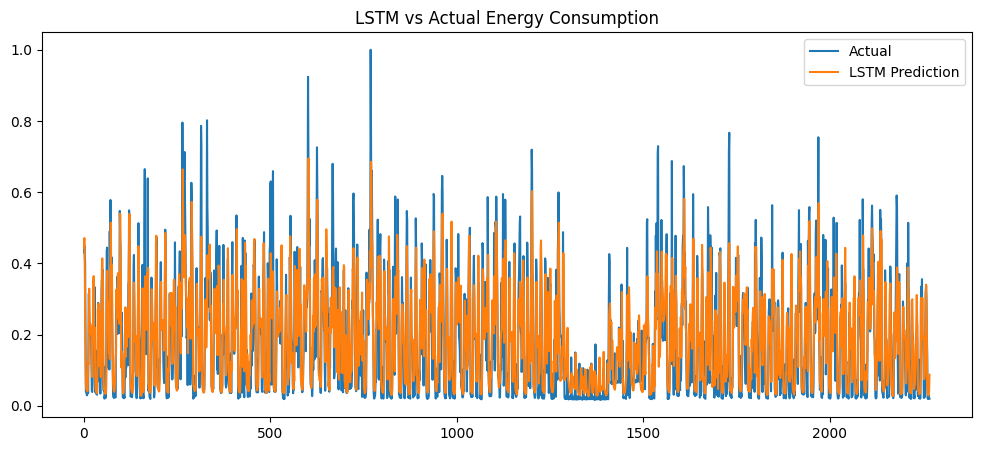

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_seq, label="Actual")
plt.plot(y_pred_lstm, label="LSTM Prediction")
plt.legend()
plt.title("LSTM vs Actual Energy Consumption")
plt.show()


In [ ]:
model.save("lstm_energy_model.keras")

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("lstm_energy_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
target_series = df_feat[['Global_active_power']].values


In [ ]:
def create_sequences_univariate(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 24
X_seq, y_seq = create_sequences_univariate(target_series, time_steps)


In [ ]:
split = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]


In [ ]:
model = Sequential([
    LSTM(50, input_shape=(time_steps, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0211 - val_loss: 0.0165
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0117 - val_loss: 0.0148
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0110 - val_loss: 0.0142
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0102 - val_loss: 0.0139
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0105 - val_loss: 0.0138
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0100 - val_loss: 0.0135
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0101 - val_loss: 0.0130
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0093 - val_loss: 0.0130
Epoch 9/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0105 - val_loss: 0.0129
Epoch 10/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0096 - val_loss: 0.0128
Epoch 11/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0098 - val_loss: 0.0129
Epoch 12/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
y_pred_lstm = model.predict(X_test_seq)

mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))

print("Improved LSTM RMSE:", rmse_lstm)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Improved LSTM RMSE: 0.10439034531148147


> An LSTM model was implemented to capture temporal dependencies in energy consumption. However, experimental results showed that the baseline Linear Regression model achieved lower RMSE (0.0458) compared to LSTM (0.1043). This indicates that the dataset exhibits strong linear characteristics and short-term autocorrelation, making simpler regression-based models more effective. Therefore, the baseline model was selected for deployment.




